Using Euler time stepping

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import PyCO2SYS as pyco2
import xarray as xr
from datetime import datetime
from scipy.optimize import minimize

In [2]:
# directories
rawDir = "../data/raw/"
interimDir = "../data/interim/"
processedDir = "../data/processed/"
imgDir = "../img/"

In [3]:
# --- Parameters from the paper (GB site) ---
params = {
    'T1_star': 9.51, # °C
    'T2_star': 10.00, # °C
    'S1_star': 32.47, # psu
    'S2_star': 32.44, # psu
    'A_1T': 9.00, # °C
    'A_1S': -0.75, # psu
    'A_2T': 3.50, # °C
    'phi_1T': -0.97, # radians
    'phi_1S': -0.45, # radians
    'phi_2T': -1.54, # radians
    'tau_1T': 0.09, # yr
    'tau_1S': 0.27, # yr
    'tau_2T': 0.15, # yr
    'tau_2': 0.15, # yr
    'KD': 1e-5, # we need it in m^2/yr!
    'NPP': 1.0, # gC/m2^/day needs to be converted to m*µmolC/kg/yr
    'Fratio': 0.25, # unitless ?
    'PICPOC': 0.04, # unitless ?
    'Remin': 1.0, # unitless ?
    'h1': 25.0, # m
    'h2': 45.0 # m
}

NCP = params['NPP'] * params['Fratio']
# pCO2_atm is the atmospheric partial pressure of CO2
pCO2_atm = 420  # in µatm
# K_air is the gas transfer velocity calculated as in Wanninkhof [3] with a seasonally variable wind speed determined from the nearest NDBC monitoring buoy (GB, Station 44011; MA, Station 44009)
K_air = 0.251  # we need it in m/yr!

delta_z = (params["h1"] + params["h2"])/2

In [4]:
# --- Initial Conditions (GB site) ---
initial_state = np.array([
    23.29,  # T1
    8.52,   # T2
    31.67,  # S1
    32.95,  # S2
    1890.1, # DIC1
    2019.0, # DIC2
    2160.6, # TA1
    2125.7  # TA2
])


In [5]:
# --- Density Function (linear approximation) --- (more realistic density, with eg TEOS-10)
def density(T, S):
    rho0 = 1025 # reference density kg/m3
    alpha = 0.2 # thermal expansion coefficient 
    beta = 0.8 # haline contraction coefficient
    return rho0 * (1 - alpha * (T - 10) + beta * (S - 35))

In [6]:
# --- Simulation Settings ---
dt = 0.1  # years
total_time = 10  # years
nt = int(total_time / dt) # number of time steps
times = np.linspace(0, total_time, nt + 1)

In [7]:
# --- Initialize output ---
state = initial_state.copy()
states = [state.copy()]
pH_values = []
pCO2_surf_values = []
J_air_values = []


# --- Euler Integration Loop ---
for t in times[1:]:
    T1, T2, S1, S2, DIC1, DIC2, TA1, TA2 = state # units °C, psu, µmol/kg, µmol/kg
    p = params

    # Seasonal Forcing Terms
    seasonal_T1 = p['A_1T'] * np.cos(2 * np.pi * t + p['phi_1T']) # °C
    seasonal_T2 = p['A_2T'] * np.cos(2 * np.pi * t + p['phi_2T']) # °C
    seasonal_S1 = p['A_1S'] * np.cos(2 * np.pi * t + p['phi_1S']) # psu

    # Derivatives
    dT1 = (p['T1_star'] - seasonal_T1 - T1) / p['tau_1T'] # °C/yr
    dT2 = (p['T2_star'] - seasonal_T2 - T2) / p['tau_2T'] # °C/yr
    dS1 = (p['S1_star'] - seasonal_S1 - S1) / p['tau_1S'] # psu/yr
    dS2 = (p['S2_star'] - S2) / p['tau_2']

    # Calculate pCO2surf using PyCO2SYS
    co2sys_result = pyco2.sys(
    par1=TA1,
    par2=DIC1,
    par1_type=1,  # 1 = TA
    par2_type=2,  # 2 = DIC
    salinity=S1,
    temperature=T1,
    pressure=0,  # sea surface pressure, in dbar

    total_silicate=0.0,     # explicitly zero
    total_phosphate=0.0,    # explicitly zero

    opt_k_carbonic=4,       # 4 = Mehrbach refit by Dickson & Millero (2007)
    opt_k_bisulfate=1,      # 1 = Dickson (1990)
    )

    pCO2_surf = co2sys_result['pCO2'] # µatm
    pCO2_surf_values.append(pCO2_surf)

    pH = co2sys_result['pH'] 
    pH_values.append(pH)
    # alpha_CO2 is the CO2 solubility calculated as in Weiss [4]
    alpha_CO2 = co2sys_result["k_CO2"]  # This gives CO₂ solubility we need µmol/kg*µatm!!!!

    # CO2 flux (positive into ocean)
    J_air = K_air * alpha_CO2 * (pCO2_atm - pCO2_surf) # m*µmol/kg/yr
    J_air_values.append(J_air)

    dDIC1 = (J_air + p['KD'] * ((DIC2 - DIC1) / delta_z) - NCP * (1 + p['PICPOC'])) / p['h1'] # µmol/kg/yr
    dDIC2 = (p['Remin'] * NCP * (1 + p['PICPOC']) - p['KD'] * ((DIC2 - DIC1) / delta_z)) / p['h2'] # µmol/kg/yr
    dTA1 = (p['KD'] * ((TA2 - TA1) / delta_z) - 2 * NCP * p['PICPOC']) / p['h1'] # µmol/kg/yr
    dTA2 = (-p['KD'] * ((TA2 - TA1) / delta_z) + 2 * NCP * p['PICPOC']) / p['h2'] # µmol/kg/yr

    # Tentative Euler Step
    T1_hat = T1 + dt * dT1 # °C
    T2_hat = T2 + dt * dT2 # °C
    S1_hat = S1 + dt * dS1 # psu
    S2_hat = S2 + dt * dS2 # psu
    DIC1_hat = DIC1 + dt * dDIC1 # µmol/kg
    DIC2_hat = DIC2 + dt * dDIC2 # µmol/kg
    TA1_hat = TA1 + dt * dTA1   # µmol/kg
    TA2_hat = TA2 + dt * dTA2  # µmol/kg

    # Potential Density Mixing Condition
    if density(T1_hat, S1_hat) > density(T2_hat, S2_hat):
        mix_T = (p['h1'] * T1_hat + p['h2'] * T2_hat) / (p['h1'] + p['h2']) # °C
        mix_S = (p['h1'] * S1_hat + p['h2'] * S2_hat) / (p['h1'] + p['h2']) # psu
        mix_DIC = (p['h1'] * DIC1_hat + p['h2'] * DIC2_hat) / (p['h1'] + p['h2']) # µmol/kg
        mix_TA = (p['h1'] * TA1_hat + p['h2'] * TA2_hat) / (p['h1'] + p['h2'])  # µmol/kg
        state = np.array([mix_T, mix_T, mix_S, mix_S, mix_DIC, mix_DIC, mix_TA, mix_TA])
    else:
        state = np.array([T1_hat, T2_hat, S1_hat, S2_hat, DIC1_hat, DIC2_hat, TA1_hat, TA2_hat])

    states.append(state.copy())

# --- Save Results ---
columns = ['T1', 'T2', 'S1', 'S2', 'DIC1', 'DIC2', 'TA1', 'TA2']
df = pd.DataFrame(states, columns=columns)
df['time'] = times

# Add a starting dummy value to match length
pH_values.insert(0, np.nan)
pCO2_surf_values.insert(0, np.nan)
J_air_values.insert(0, np.nan)

# Add to dataframe
df['pH'] = pH_values
df['pCO2_surf'] = pCO2_surf_values
df['J_air'] = J_air_values

# Save to CSV
df.to_csv(processedDir + "GB_model_output.csv", index=False)

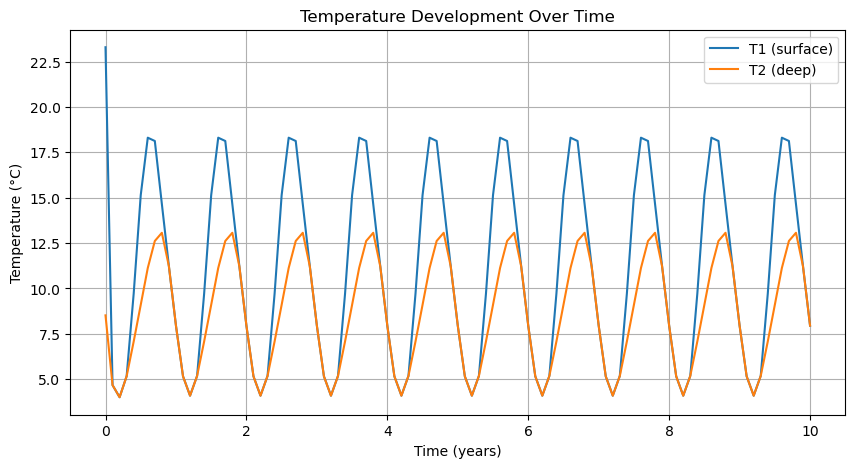

In [8]:
# --- Plotting: Temperature ---
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['T1'], label='T1 (surface)')
plt.plot(df['time'], df['T2'], label='T2 (deep)')
plt.xlabel('Time (years)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Development Over Time')
plt.legend()
plt.grid(True)
plt.savefig(imgDir + "model_temperature_development.png", dpi=300)
plt.show()

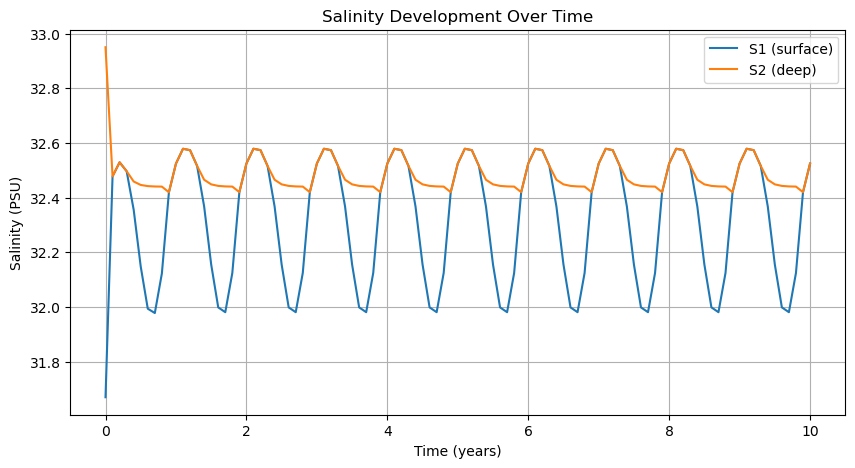

In [9]:
# --- Plotting: Salinity ---
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['S1'], label='S1 (surface)')
plt.plot(df['time'], df['S2'], label='S2 (deep)')
plt.xlabel('Time (years)')
plt.ylabel('Salinity (PSU)')
plt.title('Salinity Development Over Time')
plt.legend()
plt.grid(True)
plt.savefig(imgDir + "model_salinity_development.png", dpi=300)
plt.show()

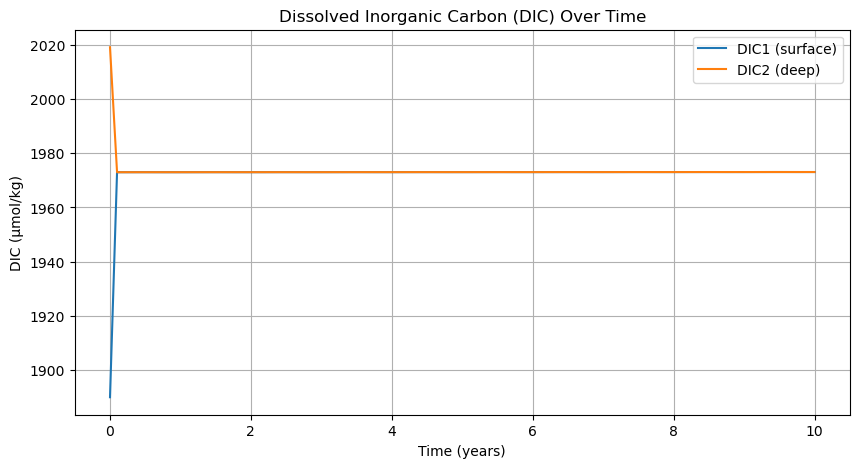

In [10]:
# --- Plotting: Disolved Inorganic Carbon ---
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['DIC1'], label='DIC1 (surface)')
plt.plot(df['time'], df['DIC2'], label='DIC2 (deep)')
plt.xlabel('Time (years)')
plt.ylabel('DIC (µmol/kg)')
plt.title('Dissolved Inorganic Carbon (DIC) Over Time')
plt.legend()
plt.grid(True)
plt.savefig(imgDir + "model_DIC_development.png", dpi=300)
plt.show()


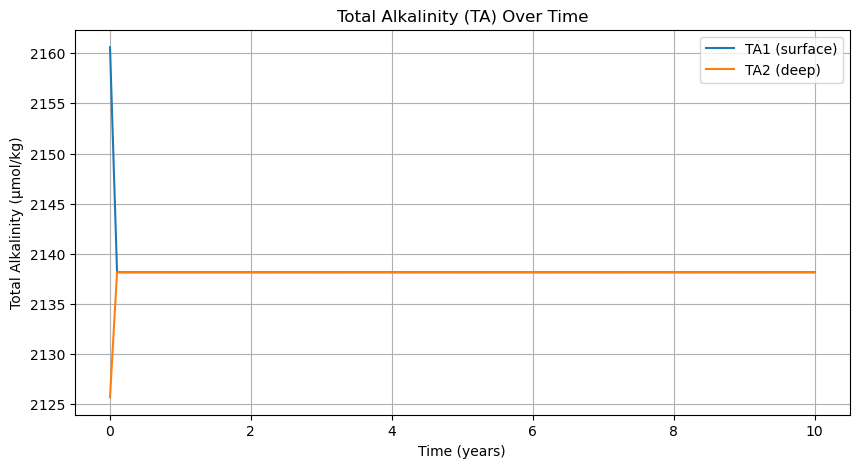

In [11]:
# --- Plotting: Alkalinity ---
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['TA1'], label='TA1 (surface)')
plt.plot(df['time'], df['TA2'], label='TA2 (deep)')
plt.xlabel('Time (years)')
plt.ylabel('Total Alkalinity (µmol/kg)')
plt.title('Total Alkalinity (TA) Over Time')
plt.legend()
plt.grid(True)
plt.savefig(imgDir + "model_TA_development.png", dpi=300)
plt.show()


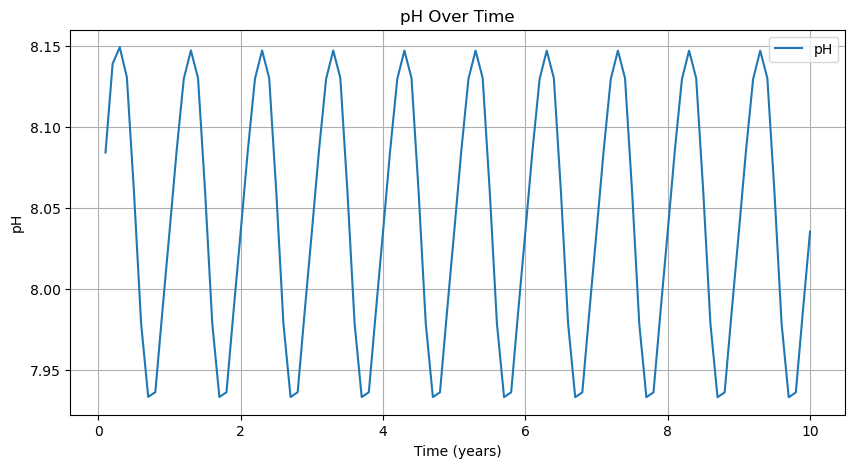

In [12]:
# --- Plotting: pH ---
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['pH'], label='pH')
plt.xlabel('Time (years)')
plt.ylabel('pH')
plt.title('pH Over Time')
plt.legend()
plt.grid(True)
plt.savefig(imgDir + "model_pH_development.png", dpi=300)
plt.show()

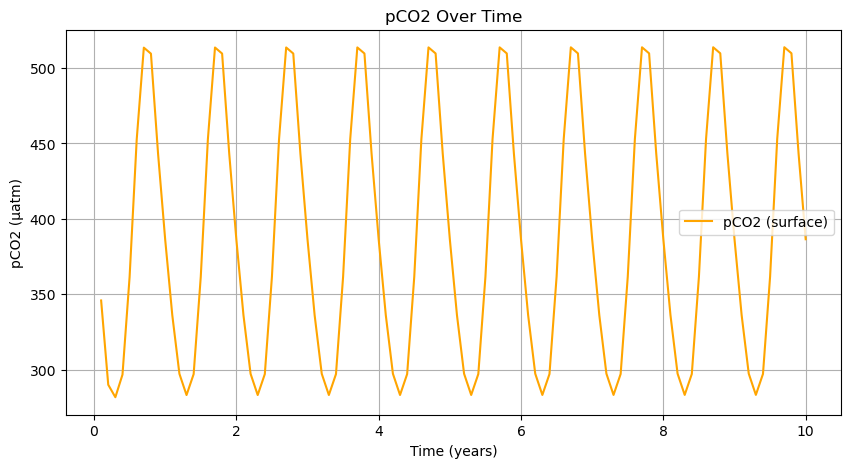

In [13]:
# --- Plotting: pCO2 ---
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['pCO2_surf'], label='pCO2 (surface)', color='orange')
plt.xlabel('Time (years)')
plt.ylabel('pCO2 (µatm)')
plt.title('pCO2 Over Time')
plt.legend()
plt.grid(True)
plt.savefig(imgDir + "model_pCO2_development.png", dpi=300)
plt.show()

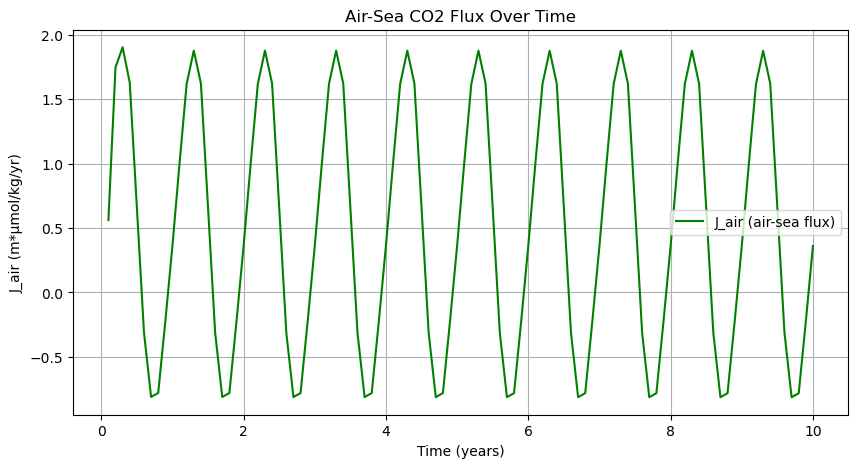

In [14]:
# --- Plotting: J_air ---
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['J_air'], label='J_air (air-sea flux)', color='green')
plt.xlabel('Time (years)')
plt.ylabel('J_air (m*µmol/kg/yr)')
plt.title('Air-Sea CO2 Flux Over Time')
plt.legend()
plt.grid(True)
plt.savefig(imgDir + "model_J_air_development.png", dpi=300)
plt.show()

# Compare to SOCAT data

In [15]:
# Open the dataset
socat_data = xr.open_dataset(rawDir + "SOCATv2024_tracks_gridded_monthly.nc")

# List all variables
print("Variables:\n", list(socat_data.data_vars))

Variables:
 ['tmnth_bnds', 'count_ncruise', 'fco2_count_nobs', 'fco2_ave_weighted', 'fco2_ave_unwtd', 'fco2_min_unwtd', 'fco2_max_unwtd', 'fco2_std_weighted', 'fco2_std_unwtd', 'sst_count_nobs', 'sst_ave_weighted', 'sst_ave_unwtd', 'sst_min_unwtd', 'sst_max_unwtd', 'sst_std_weighted', 'sst_std_unwtd', 'salinity_count_nobs', 'salinity_ave_weighted', 'salinity_ave_unwtd', 'salinity_min_unwtd', 'salinity_max_unwtd', 'salinity_std_weighted', 'salinity_std_unwtd', 'lat_offset_unwtd', 'lon_offset_unwtd']


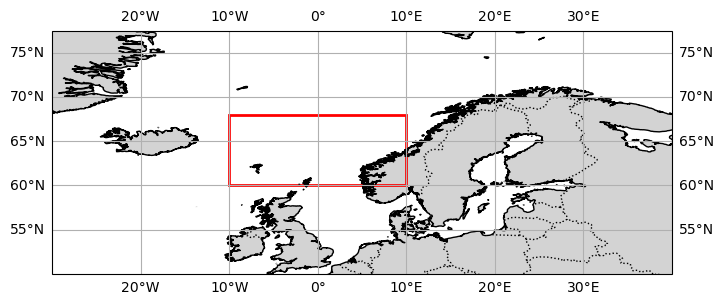

In [16]:
# --- Define your lat/lon extent ---
lat_min, lat_max = 60, 68
lon_min, lon_max = -10, 10

# --- Create a map ---
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add coastlines and features
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.set_extent([-30, 40, 50, 75])  # wider map view around area

# --- Add rectangle for your lat/lon range ---
rect = Rectangle(
    (lon_min, lat_min),             # lower-left corner
    lon_max - lon_min,              # width (in degrees)
    lat_max - lat_min,              # height (in degrees)
    linewidth=2,
    edgecolor='red',
    facecolor='none',
    transform=ccrs.PlateCarree()
)

ax.add_patch(rect)
ax.gridlines(draw_labels=True)
plt.show()


In [17]:
lat_range = slice(60, 68) 
lon_range = slice(-10, 10)  

# Extract relevant variables and region
norway_data = socat_data[[
    'sst_ave_weighted', 
    'salinity_ave_weighted', 
    'fco2_ave_weighted'
]].sel(ylat=lat_range, xlon=lon_range)

# Filter time range from 2010 to 2020
norway_data = norway_data.sel(tmnth=slice("2010-01-01", "2019-12-31"))
area_mean = norway_data.mean(dim=['xlon', 'ylat'], skipna=True)


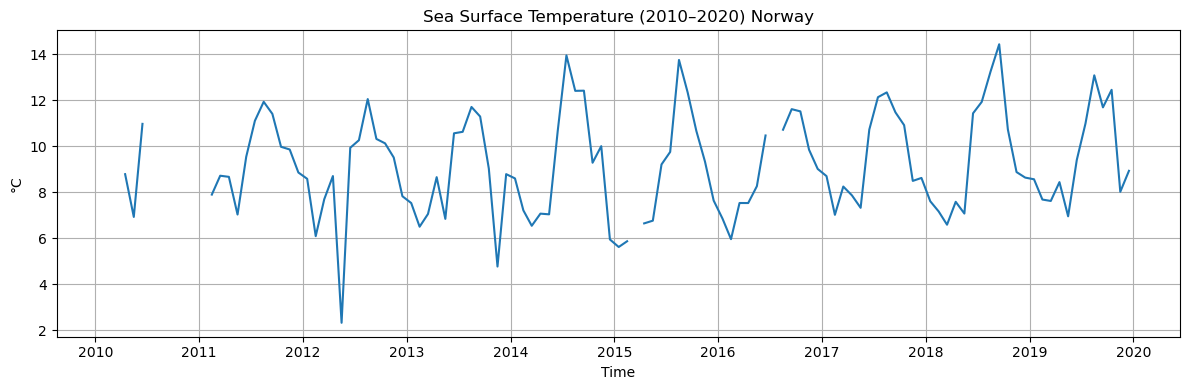

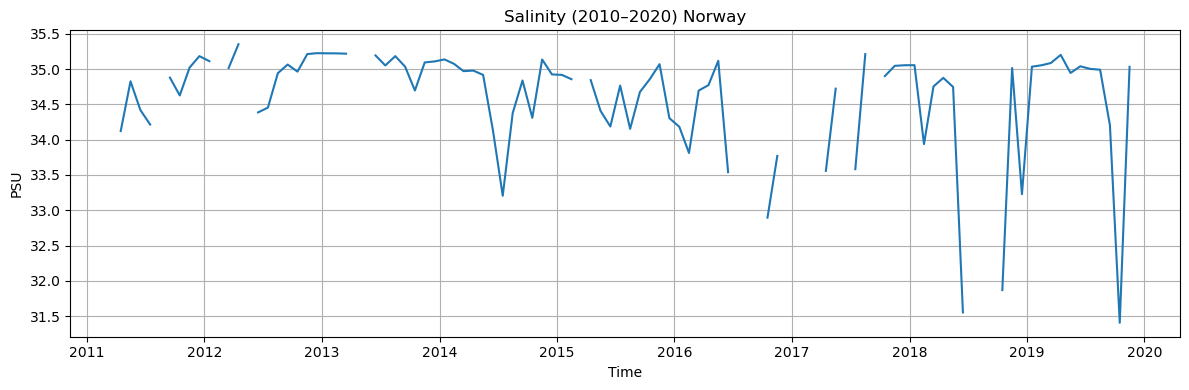

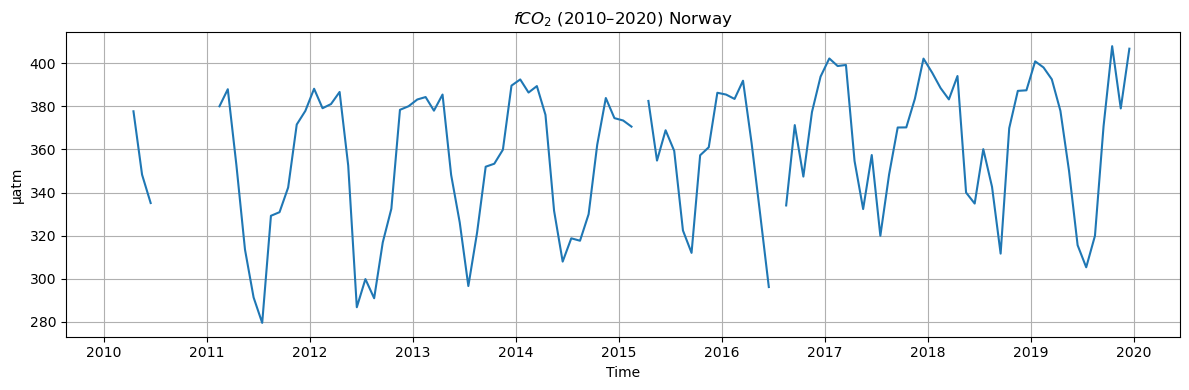

In [18]:
# Plot time series for each variable
def plot_time_series(var, label, ylabel):
    plt.figure(figsize=(12, 4))
    plt.plot(area_mean.tmnth, area_mean[var], label=label)
    plt.title(f"{label} (2010–2020) Norway")
    plt.xlabel("Time")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(imgDir + f"{var}_time_series.png", dpi=300)
    plt.show()

# Plot each variable
plot_time_series('sst_ave_weighted', 'Sea Surface Temperature', '°C')
plot_time_series('salinity_ave_weighted', 'Salinity', 'PSU')
plot_time_series('fco2_ave_weighted', r'$fCO_2$', 'µatm')

In [19]:
# Base time for your model (e.g. Jan 1, 2010)
start_year = datetime(2010, 1, 1)

# Convert model time in fractional years to actual dates
df['date'] = pd.to_datetime(df['time'] * 365.25, unit='D', origin=start_year)

# Convert area mean to pandas DataFrame
obs_mean_df = area_mean.to_dataframe().reset_index()

# Rename for consistency
obs_mean_df = obs_mean_df.rename(columns={
    'sst_ave_weighted': 'T_obs',
    'salinity_ave_weighted': 'S_obs',
    'fco2_ave_weighted': 'pCO2_obs'
})


In [20]:
print(obs_mean_df.head())

                tmnth     T_obs  S_obs    pCO2_obs
0 2010-01-16 12:00:00       NaN    NaN         NaN
1 2010-02-15 00:00:00  6.032448    NaN  374.942352
2 2010-03-16 12:00:00       NaN    NaN         NaN
3 2010-04-16 00:00:00  8.781796    NaN  377.691956
4 2010-05-16 12:00:00  6.923958    NaN  348.295441


In [21]:
print(df.head())

          T1        T2         S1         S2         DIC1         DIC2  \
0  23.290000  8.520000  31.670000  32.950000  1890.100000  2019.000000   
1   4.677432  4.677432  32.477739  32.477739  1972.965088  1972.965088   
2   4.010323  4.010323  32.529185  32.529185  1972.967584  1972.967584   
3   5.170154  5.170154  32.496569  32.496569  1972.970303  1972.970303   
4   9.717018  7.077328  32.355392  32.458856  1972.975776  1972.970881   

           TA1          TA2  time        pH   pCO2_surf     J_air  \
0  2160.600000  2125.700000   0.0       NaN         NaN       NaN   
1  2138.164286  2138.164286   0.1  8.084436  345.871513  0.561739   
2  2138.164286  2138.164286   0.2  8.139175  289.959002  1.747270   
3  2138.164286  2138.164286   0.3  8.149397  281.693030  1.903419   
4  2138.164206  2138.164330   0.4  8.130896  296.650360  1.628010   

                           date  
0 2010-01-01 00:00:00.000000000  
1 2010-02-06 12:35:59.999999965  
2 2010-03-15 01:11:59.999999939  
3 20

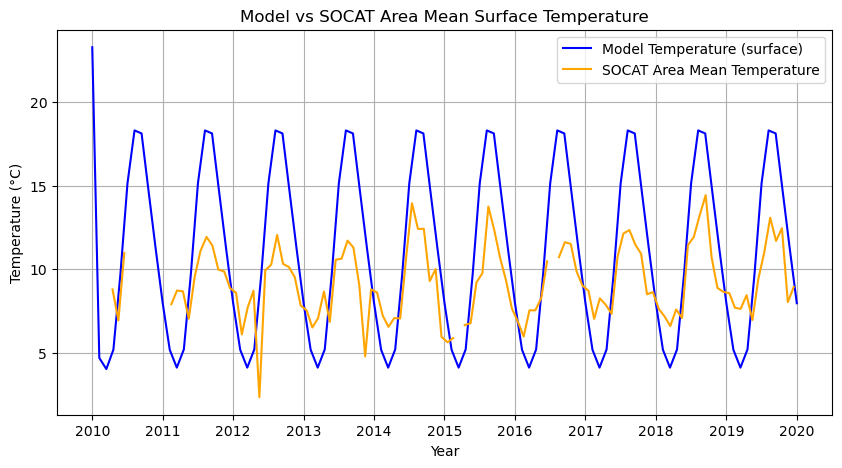

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['T1'], label='Model Temperature (surface)', color='blue')
plt.plot(obs_mean_df['tmnth'], obs_mean_df['T_obs'], label='SOCAT Area Mean Temperature', color='orange')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Model vs SOCAT Area Mean Surface Temperature')
plt.grid(True)
plt.legend()
plt.savefig(imgDir + "GB_model_vs_SOCAT_Temperature.png", dpi=300)
plt.show()


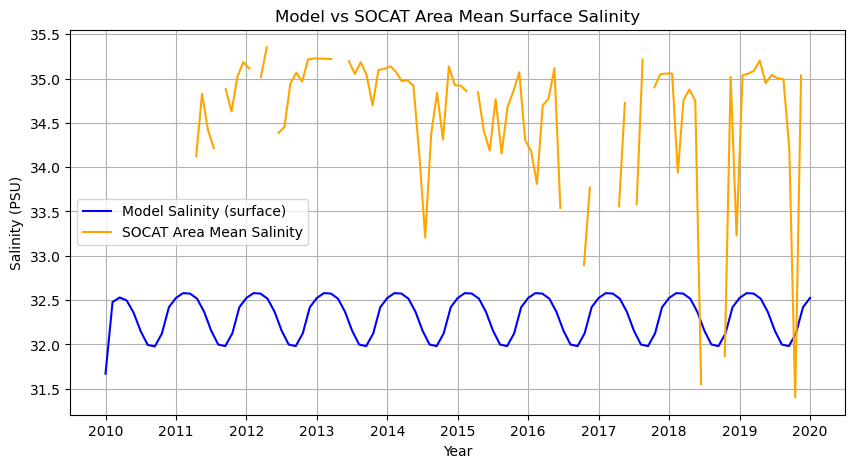

In [23]:
plt.figure(figsize=(10 ,5))
plt.plot(df['date'], df['S1'], label='Model Salinity (surface)', color='blue')
plt.plot(obs_mean_df['tmnth'], obs_mean_df['S_obs'], label='SOCAT Area Mean Salinity', color='orange')
plt.xlabel('Year')
plt.ylabel('Salinity (PSU)')
plt.title('Model vs SOCAT Area Mean Surface Salinity')
plt.grid(True)
plt.legend()
plt.savefig(imgDir + "GB_model_vs_SOCAT_Salinity.png", dpi=300)
plt.show()

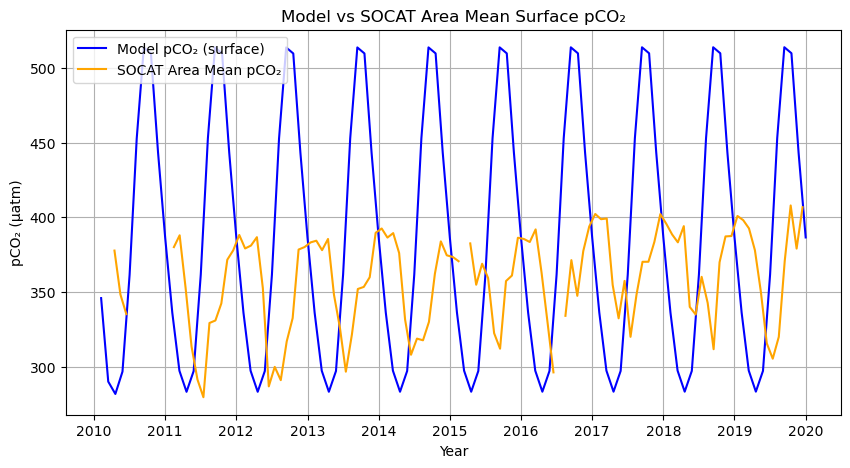

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['pCO2_surf'], label='Model pCO₂ (surface)', color='blue')
plt.plot(obs_mean_df['tmnth'], obs_mean_df['pCO2_obs'], label='SOCAT Area Mean pCO₂', color='orange')
plt.xlabel('Year')
plt.ylabel('pCO₂ (µatm)')
plt.title('Model vs SOCAT Area Mean Surface pCO₂')
plt.grid(True)
plt.legend()
plt.savefig(imgDir + "GB_model_vs_SOCAT_pCO2.png", dpi=300)
plt.show()


## Unconstrained optimization

## Model as function

In [25]:
obs_mean_df['tmnth'] = obs_mean_df['tmnth'].dt.to_period('M').dt.to_timestamp(how='E')
obs_mean_df['tmnth'] = obs_mean_df['tmnth'].dt.normalize()

print(obs_mean_df.head())

       tmnth     T_obs  S_obs    pCO2_obs
0 2010-01-31       NaN    NaN         NaN
1 2010-02-28  6.032448    NaN  374.942352
2 2010-03-31       NaN    NaN         NaN
3 2010-04-30  8.781796    NaN  377.691956
4 2010-05-31  6.923958    NaN  348.295441


In [26]:
def run_model_with_params(param_values, param_names, fixed_params, initial_state, times, NCP, pCO2_atm, K_air, delta_z):
    # Update params with values to optimize
    p = fixed_params.copy()
    for name, val in zip(param_names, param_values):
        p[name] = val

    state = initial_state.copy()
    states = [state.copy()]

    for t in times[1:]:
        T1, T2, S1, S2, DIC1, DIC2, TA1, TA2 = state

        seasonal_T1 = p['A_1T'] * np.cos(2 * np.pi * t + p['phi_1T'])
        seasonal_T2 = p['A_2T'] * np.cos(2 * np.pi * t + p['phi_2T'])
        seasonal_S1 = p['A_1S'] * np.cos(2 * np.pi * t + p['phi_1S'])

        dT1 = (p['T1_star'] - seasonal_T1 - T1) / p['tau_1T']
        dT2 = (p['T2_star'] - seasonal_T2 - T2) / p['tau_2T']
        dS1 = (p['S1_star'] - seasonal_S1 - S1) / p['tau_1S']
        dS2 = (p['S2_star'] - S2) / p['tau_2']

        co2sys_result = pyco2.sys(
            par1=TA1, par2=DIC1,
            par1_type=1, par2_type=2,
            salinity=S1, temperature=T1, pressure=0,
            total_silicate=0.0, total_phosphate=0.0,
            opt_k_carbonic=4, opt_k_bisulfate=1)

        alpha_CO2 = co2sys_result['k_CO2']
        pCO2_surf = co2sys_result['pCO2']
        J_air = K_air * alpha_CO2 * (pCO2_atm - pCO2_surf)

        dDIC1 = (J_air + p['KD'] * ((DIC2 - DIC1) / delta_z) - NCP * (1 + p['PICPOC'])) / p['h1']
        dDIC2 = (p['Remin'] * NCP * (1 + p['PICPOC']) - p['KD'] * ((DIC2 - DIC1) / delta_z)) / p['h2']
        dTA1 = (p['KD'] * ((TA2 - TA1) / delta_z) - 2 * NCP * p['PICPOC']) / p['h1']
        dTA2 = (-p['KD'] * ((TA2 - TA1) / delta_z) + 2 * NCP * p['PICPOC']) / p['h2']

        dt = times[1] - times[0]
        T1_hat = T1 + dt * dT1
        T2_hat = T2 + dt * dT2
        S1_hat = S1 + dt * dS1
        S2_hat = S2 + dt * dS2
        DIC1_hat = DIC1 + dt * dDIC1
        DIC2_hat = DIC2 + dt * dDIC2
        TA1_hat = TA1 + dt * dTA1
        TA2_hat = TA2 + dt * dTA2

        def density(T, S):
            rho0 = 1025
            alpha = 0.2
            beta = 0.8
            return rho0 * (1 - alpha * (T - 10) + beta * (S - 35))

        if density(T1_hat, S1_hat) > density(T2_hat, S2_hat):
            mix_T = (p['h1'] * T1_hat + p['h2'] * T2_hat) / (p['h1'] + p['h2'])
            mix_S = (p['h1'] * S1_hat + p['h2'] * S2_hat) / (p['h1'] + p['h2'])
            mix_DIC = (p['h1'] * DIC1_hat + p['h2'] * DIC2_hat) / (p['h1'] + p['h2'])
            mix_TA = (p['h1'] * TA1_hat + p['h2'] * TA2_hat) / (p['h1'] + p['h2'])
            state = np.array([mix_T, mix_T, mix_S, mix_S, mix_DIC, mix_DIC, mix_TA, mix_TA])
        else:
            state = np.array([T1_hat, T2_hat, S1_hat, S2_hat, DIC1_hat, DIC2_hat, TA1_hat, TA2_hat])

        states.append(state.copy())

    df = pd.DataFrame(states, columns=['T1', 'T2', 'S1', 'S2', 'DIC1', 'DIC2', 'TA1', 'TA2'])
    df['time'] = times
    # Base time for your model (e.g. Jan 1, 2010)
    start_year = datetime(2010, 1, 1)
    # Convert model time in fractional years to actual dates
    df['date'] = pd.to_datetime(df['time'] * 365.25, unit='D', origin=start_year)
    return df[['date', 'T1', 'S1']]

In [27]:
# Expansion coefficients from the paper
alpha = 0.2  # thermal expansion coefficient
beta = 0.8   # haline contraction coefficient

# Parameters we want to optimize
param_names = ['T1_star', 'S1_star', 'tau_1T', 'tau_1S']

def cost_function(param_values):

    # Run model with given parameter values
    model_df = run_model_with_params(
        param_values=param_values,
        param_names=param_names,
        fixed_params=params,
        initial_state=initial_state,
        times=times,
        NCP=NCP,
        pCO2_atm=pCO2_atm,
        K_air=K_air,
        delta_z=delta_z
    )

    model_monthly = model_df.set_index('date').resample('ME').mean().reset_index()
    model_monthly['date'] = model_monthly['date'].dt.normalize()


    # Merge with monthly mean observational data
    merged = pd.merge(model_monthly, obs_mean_df, left_on='date', right_on='tmnth', how='inner')
    print("Model dates:", model_monthly['date'].unique())
    print("Observation dates:", obs_mean_df['tmnth'].unique())

    # Weighted squared difference
    temp_error = alpha * (merged['T1'] - merged['T_obs'])**2
    sal_error = beta * (merged['S1'] - merged['S_obs'])**2

    # Total cost
    return (temp_error + sal_error).sum()


In [84]:
# Initial guesses
x0 = [params[k] for k in param_names]

# Bounds for parameters
bounds = [
    (5, 25),     # T1_star
    (30, 35),    # S1_star
    (0.01, 1.0), # tau_1T
    (0.01, 1.0)  # tau_1S
]

# Run optimization
result = minimize(cost_function, x0, method='L-BFGS-B', bounds=bounds)

# Output
best_params = {k: v for k, v in zip(param_names, result.x)}
print("Best-fit parameters:", best_params)
print("Final cost:", result.fun)

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:84: RuntimeWarning: invalid value encountered in sqrt
  * Sal**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:86: RuntimeWarning: invalid value encountered in power
  + (-0.00291179 + 0.0000209968 * TempK) * Sal**1.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:99: RuntimeWarning: invalid value encountered in scalar power
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
c:\Users\siebert\AppData\Local\miniconda3\envs\seao2cdr\Lib\site-packages\PyCO2SYS\equilibria\p1atm.py:113: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 874 / TempK - 9.68 + 0.111 * Sal**0.5
c:\Users\siebert\A

Model dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-30 00:00:00',
 '2019-07-31 00:00:00', '2019-08-31 00:00:00', '2019-09-30 00:00:00',
 '2019-10-31 00:00:00', '2019-11-30 00:00:00', '2019-12-31 00:00:00',
 '2020-01-31 00:00:00']
Length: 121, dtype: datetime64[ns]
Observation dates: <DatetimeArray>
['2010-01-31 00:00:00', '2010-02-28 00:00:00', '2010-03-31 00:00:00',
 '2010-04-30 00:00:00', '2010-05-31 00:00:00', '2010-06-30 00:00:00',
 '2010-07-31 00:00:00', '2010-08-31 00:00:00', '2010-09-30 00:00:00',
 '2010-10-31 00:00:00',
 ...
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2

KeyboardInterrupt: 

## Plot Optimization Results

In [ ]:

# Use the best-fit values from the optimizer
optimized_params = result.x  # or the dict `best_params` if you constructed one
param_names = ['T1_star', 'S1_star', 'tau_1T', 'tau_1S']

# Run model with optimized parameters
model_df_opt = run_model_with_params(
    param_values=optimized_params,
    param_names=param_names,
    fixed_params=params,
    initial_state=initial_state,
    times=times,
    NCP=NCP,
    pCO2_atm=pCO2_atm,
    K_air=K_air,
    delta_z=delta_z
)

# Normalize model dates to match observations
model_df_opt['date'] = model_df_opt['date'].dt.normalize()

# Merge
plot_df = pd.merge(model_df_opt, obs_mean_df, left_on='date', right_on='tmnth', how='inner')

In [ ]:
plt.figure(figsize=(12, 5))

# Temperature
plt.subplot(1, 2, 1)
plt.plot(plot_df['date'], plot_df['T1'], label='Model T1 (Surface Temp)', color='tab:blue')
plt.plot(plot_df['date'], plot_df['T_obs'], label='Observed Temp', color='tab:orange', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Surface Temperature')
plt.legend()
plt.grid(True)

# Salinity
plt.subplot(1, 2, 2)
plt.plot(plot_df['date'], plot_df['S1'], label='Model S1 (Surface Salinity)', color='tab:blue')
plt.plot(plot_df['date'], plot_df['S_obs'], label='Observed Salinity', color='tab:orange', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Salinity (psu)')
plt.title('Surface Salinity')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
